# Part 1
**Use this dataset (https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip) to train a CNN. Use no other data source or pretrained networks, and explain your design choices during preprocessing, model building and training. Also, cite the sources you used to borrow techniques. A test set will be provided later to judge the performance of your classifier. Please save your model checkpoints.**

Get data into memory using wget

In [9]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
!wget -qq https://www.dropbox.com/s/pan6mutc5xj5kj0/trainPart1.zip

Unzip into a folder

In [2]:
!unzip -qq trainPart1.zip

Look at all classes

In [3]:
!ls train

Sample001  Sample010  Sample019  Sample028  Sample037  Sample046  Sample055
Sample002  Sample011  Sample020  Sample029  Sample038  Sample047  Sample056
Sample003  Sample012  Sample021  Sample030  Sample039  Sample048  Sample057
Sample004  Sample013  Sample022  Sample031  Sample040  Sample049  Sample058
Sample005  Sample014  Sample023  Sample032  Sample041  Sample050  Sample059
Sample006  Sample015  Sample024  Sample033  Sample042  Sample051  Sample060
Sample007  Sample016  Sample025  Sample034  Sample043  Sample052  Sample061
Sample008  Sample017  Sample026  Sample035  Sample044  Sample053  Sample062
Sample009  Sample018  Sample027  Sample036  Sample045  Sample054


Make required imports

In [1]:
from fastai import *
from fastai.vision import *
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

Check number of classes and number of images in each class

In [3]:
all_classes = os.listdir('train')
print(len(all_classes))
for cls in all_classes:
  print(cls, len(os.listdir('train/'+cls)))

62
Sample062 40
Sample054 40
Sample002 40
Sample015 40
Sample030 40
Sample055 40
Sample008 40
Sample046 40
Sample041 40
Sample042 40
Sample035 40
Sample021 40
Sample059 40
Sample061 40
Sample052 40
Sample057 40
Sample020 40
Sample053 40
Sample018 40
Sample003 40
Sample040 40
Sample032 40
Sample010 40
Sample019 40
Sample034 40
Sample009 40
Sample043 40
Sample031 40
Sample005 40
Sample012 40
Sample013 40
Sample023 40
Sample029 40
Sample036 40
Sample033 40
Sample050 40
Sample047 40
Sample049 40
Sample026 40
Sample017 40
Sample027 40
Sample001 40
Sample028 40
Sample004 40
Sample044 40
Sample058 40
Sample038 40
Sample045 40
Sample056 40
Sample025 40
Sample007 40
Sample039 40
Sample016 40
Sample037 40
Sample048 40
Sample051 40
Sample014 40
Sample060 40
Sample024 40
Sample011 40
Sample006 40
Sample022 40


Check image sizes

In [ ]:
img = PIL.Image.open('train/Sample001/img001-001.png')
img.size

(1200, 900)

In [ ]:
#check image size for another class image
img = PIL.Image.open('train/Sample002/img002-002.png')
img.size

(1200, 900)

### Save Split

Make dataframe of all images with labels and make a stratified validation split of 0.1

In [ ]:
img_paths = []
for name in all_classes:
    path = 'train/'+ name
    img_paths.extend([os.path.join(path, image) for image in os.listdir(path)])

df = pd.DataFrame({'image': img_paths})
df['label'] = df['image'].apply(lambda x: x.split('/')[-2])

df.head()

,index,image,label
0,0,train/Sample012/img012-016.png,Sample012
1,1,train/Sample012/img012-055.png,Sample012
2,2,train/Sample012/img012-046.png,Sample012
3,3,train/Sample012/img012-019.png,Sample012
4,4,train/Sample012/img012-010.png,Sample012


In [ ]:
def split_dataframe(df):
    x_train, x_valid = train_test_split(df, stratify=df['label'], test_size=0.1, random_state=42)
    return x_train.index, x_valid.index 
train_idx, val_idx = split_dataframe(df)

In [ ]:
# df.reset_index(inplace=True)
# df['train'] = df['index'].apply(lambda x: True if x in train_idx else False)
# df.head()

,index,image,label,train
0,0,train/Sample012/img012-016.png,Sample012,False
1,1,train/Sample012/img012-055.png,Sample012,True
2,2,train/Sample012/img012-046.png,Sample012,True
3,3,train/Sample012/img012-019.png,Sample012,True
4,4,train/Sample012/img012-010.png,Sample012,True


In [ ]:
# df.to_csv('/content/drive/My Drive/MIDAS Task 2/part1.csv', index=False)

In [ ]:
# df['train'].value_counts()

True     2232
False     248
Name: train, dtype: int64

In [ ]:
# df.drop(['index', 'train'], axis=1, inplace=True)
# df.head()

,image,label
0,train/Sample012/img012-016.png,Sample012
1,train/Sample012/img012-055.png,Sample012
2,train/Sample012/img012-046.png,Sample012
3,train/Sample012/img012-019.png,Sample012
4,train/Sample012/img012-010.png,Sample012


## Get split indices

In [4]:
df = pd.read_csv('/content/drive/My Drive/MIDAS Task 2/part1.csv')
df.head()

,index,image,label,train
0,0,train/Sample012/img012-016.png,Sample012,False
1,1,train/Sample012/img012-055.png,Sample012,True
2,2,train/Sample012/img012-046.png,Sample012,True
3,3,train/Sample012/img012-019.png,Sample012,True
4,4,train/Sample012/img012-010.png,Sample012,True


In [5]:
def get_idxs(df):
    #get saved split indexes
    df.set_index('index', inplace=True)
    train_idx, val_idx = df[df['train']==True].index, df[df['train']==False].index 
    #keep just image path and label
    df.drop(['train'], axis=1, inplace=True)
    #return modified dataframe along with indexes
    return train_idx, val_idx, df

train_idx, val_idx, df = get_idxs(df)
len(train_idx), len(val_idx), df.head()

(2232, 248,                                 image      label
 index                                           
 0      train/Sample012/img012-016.png  Sample012
 1      train/Sample012/img012-055.png  Sample012
 2      train/Sample012/img012-046.png  Sample012
 3      train/Sample012/img012-019.png  Sample012
 4      train/Sample012/img012-010.png  Sample012)

## Use Image Size 224

Create data object with image size 224 and batch size 384

In [ ]:
img_size = 224
batch_size = 384
data = (ImageList.from_df(df, path='.')
        .split_by_idxs(train_idx, val_idx)
        .label_from_df(cols=['label']) 
        .transform(get_transforms(do_flip=False), size=img_size, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=batch_size).normalize()  
       )

Take a look at a batch

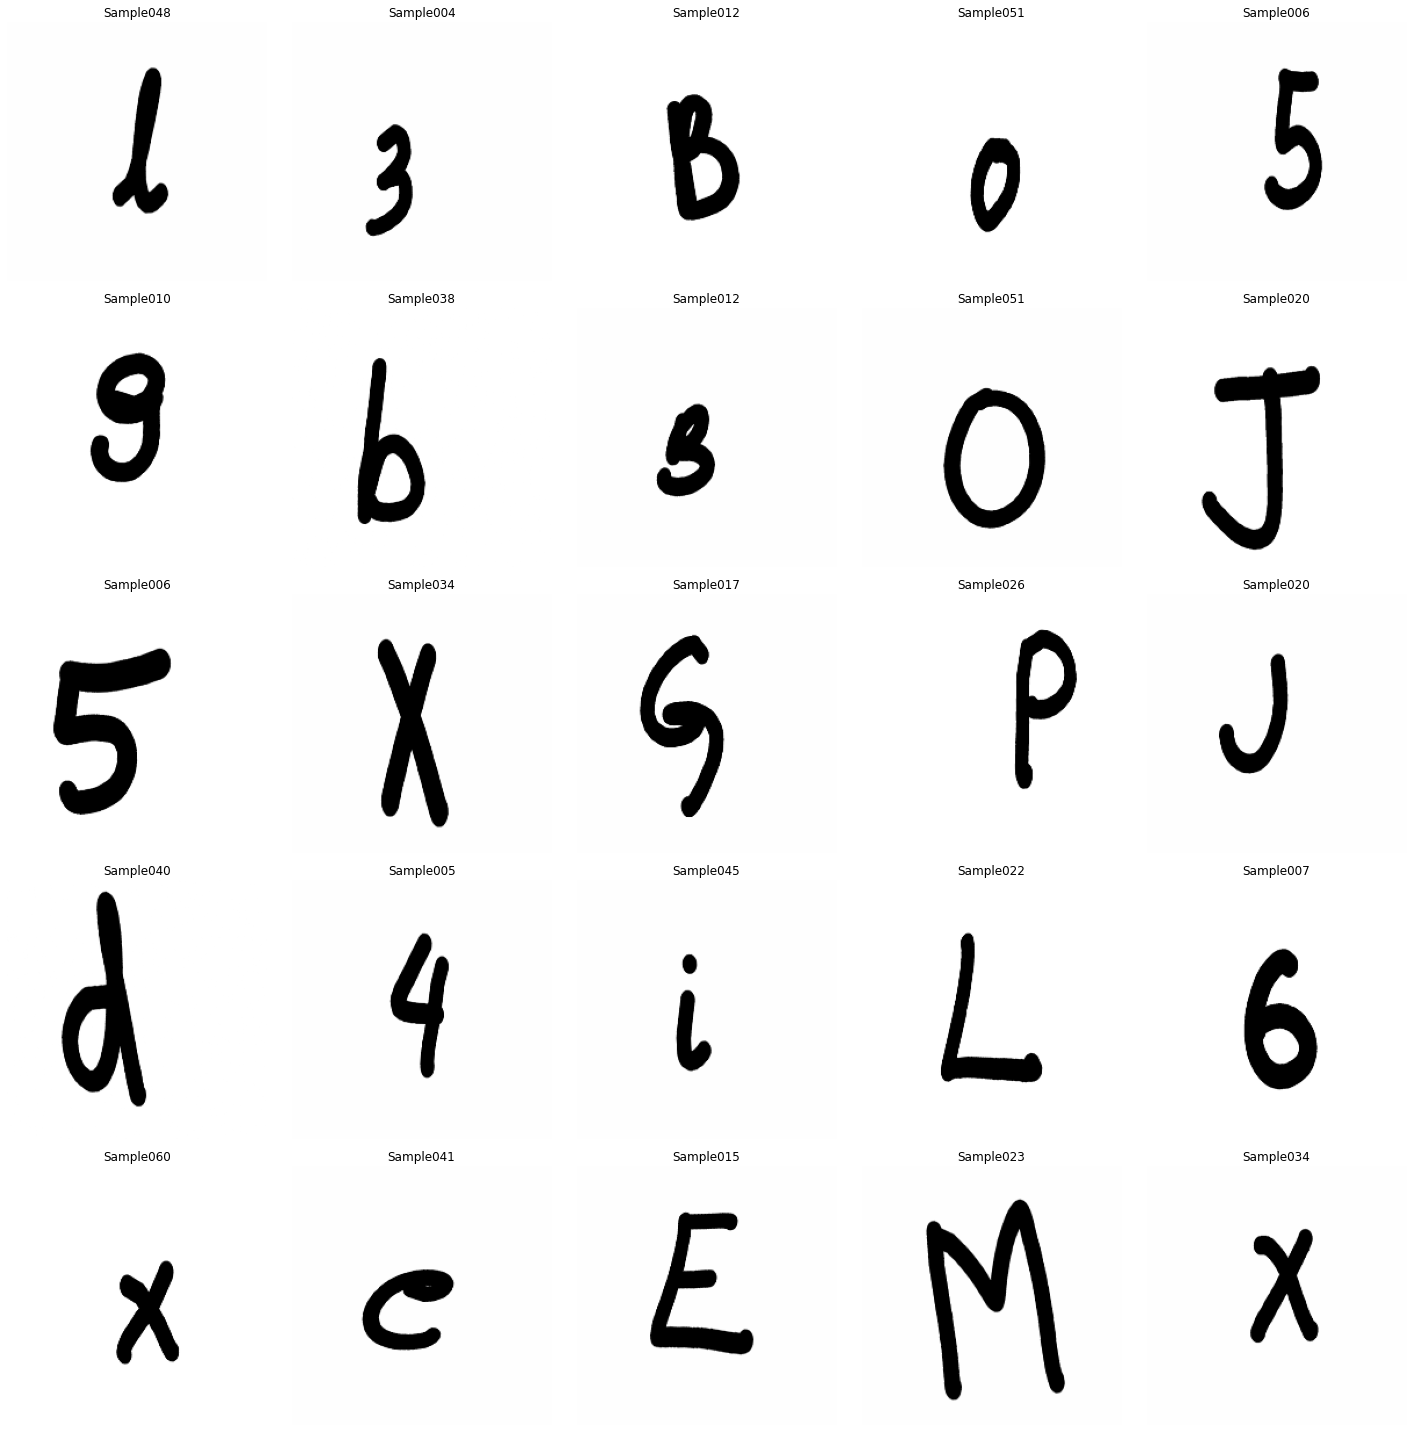

In [ ]:
data.show_batch()

Create a CNN Learner with ResNet18 architecture and random initialization

In [ ]:
learn = cnn_learner(data, models.resnet18, pretrained=False, metrics=accuracy)

Find optimum learning rate to train the model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-03
Min loss divided by 10: 2.09E-02


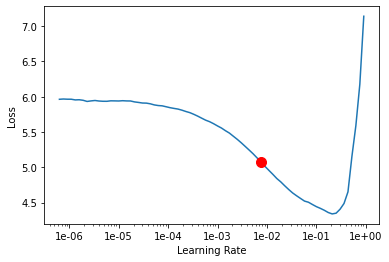

In [ ]:
learn.clip_grad()
learn.lr_find()
learn.recorder.plot(suggestion=True)

Train the model for 25 epochs using fit_one_cycle policy using max_lr=4e-2

In [ ]:
learn.fit_one_cycle(30, 3e-2)

epoch,train_loss,valid_loss,accuracy,time
0,5.281873,508.991241,0.016129,01:16
1,4.692707,9626.823242,0.016129,01:15
2,4.179867,13083.766602,0.028226,01:16
3,3.702650,13019.518555,0.020161,01:13
4,3.284301,5047.631348,0.016129,01:15
5,2.934263,3039.593994,0.016129,01:13
6,2.680838,1186.977539,0.024194,01:12
7,2.493542,695.935303,0.016129,01:13
8,2.305007,94.367584,0.040323,01:13
9,2.189071,322.853088,0.016129,01:12


Plot losses and accuracy

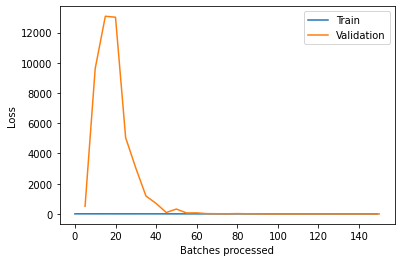

In [ ]:
learn.recorder.plot_losses()

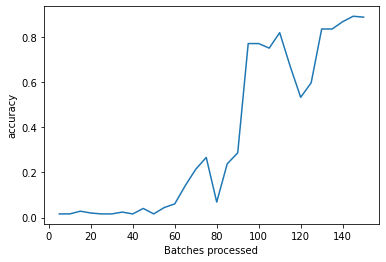

In [ ]:
learn.recorder.plot_metrics()

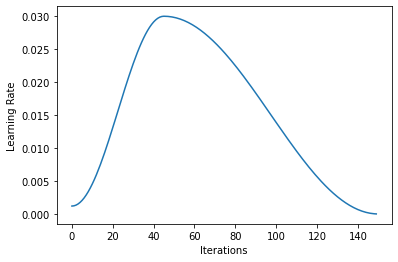

In [ ]:
learn.recorder.plot_lr()

Save model

In [ ]:
learn.save('/content/drive/My Drive/MIDAS Task 2/part1-224-s1')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.45E-03
Min loss divided by 10: 5.75E-03


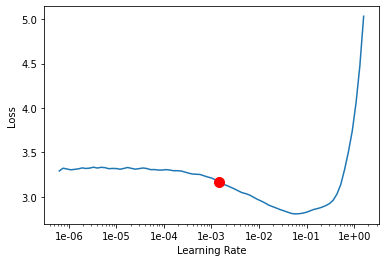

In [ ]:
learn.mixup();
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
lr = [6e-3/100, 6e-3/10, 6e-3]

In [ ]:
learn.fit_one_cycle(20, lr)

epoch,train_loss,valid_loss,accuracy,time
0,3.216755,0.325133,0.887097,01:12
1,3.218035,0.351808,0.887097,01:12
2,3.160883,0.359848,0.887097,01:12
3,3.007010,0.356295,0.895161,01:12
4,2.814126,0.364914,0.875000,01:12
5,2.630916,0.401745,0.879032,01:12
6,2.478486,0.397090,0.883065,01:13
7,2.358790,0.397537,0.875000,01:12
8,2.257690,0.405534,0.870968,01:12
9,2.171778,0.394953,0.887097,01:12


Plot losses, accuracies and learning rates over the training duration

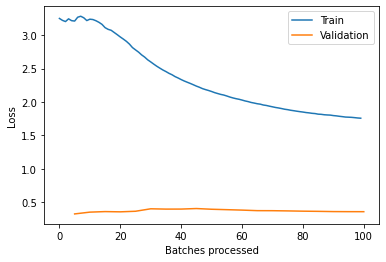

In [ ]:
learn.recorder.plot_losses()

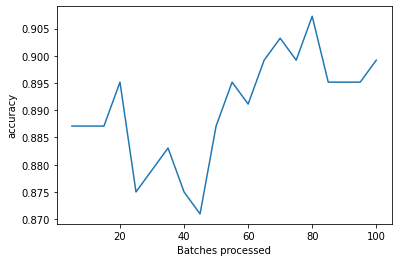

In [ ]:
learn.recorder.plot_metrics()

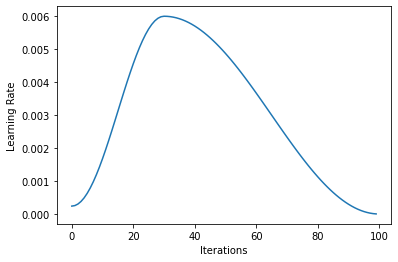

In [ ]:
learn.recorder.plot_lr()

Save model till now

In [ ]:
learn.save('/content/drive/My Drive/MIDAS Task 2/part1-224-mixup-s2')

## Image Size 299

Create databunch with image size 299

In [ ]:
img_size = 299
batch_size = 256
data_299 = (ImageList.from_df(df, path='.')
        .split_by_idxs(train_idx, val_idx)
        .label_from_df(cols=['label']) 
        .transform(get_transforms(do_flip=False), size=img_size, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=batch_size).normalize()  
       )

Create learner with data_299

In [ ]:
learn = cnn_learner(data_299, models.resnet18, pretrained=False, metrics=accuracy)

- Use pretrained weights from model trained on data with image size 224
-  Set loss function to Focal Loss
-  Add mixup augmentation
- Freeze all layers except last and find optimum learning rate to train 
- Clip gradient to 0.1

In [ ]:
learn.load('/content/drive/My Drive/MIDAS Task 2/part1-224-mixup-s2');

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=1., gamma=2.):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets, **kwargs):
        CE_loss = nn.CrossEntropyLoss(reduction='none')(inputs, targets)
        pt = torch.exp(-CE_loss)
        F_loss = self.alpha * ((1-pt)**self.gamma) * CE_loss
        return F_loss.mean()

In [ ]:
learn.loss_func = FocalLoss()

In [ ]:
learn.mixup();

In [ ]:
learn.freeze();
learn.clip_grad();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 1.00E-02


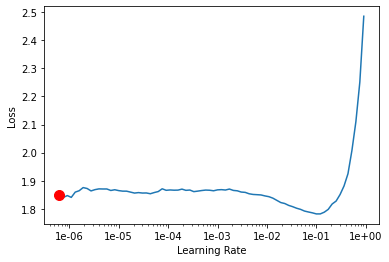

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

Fine tune just the head for 18 epochs with 1e-2

In [ ]:
learn.fit_one_cycle(18, 1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,1.819907,0.224728,0.842742,01:33
1,1.827468,0.194092,0.870968,01:32
2,1.782800,0.215547,0.899194,01:32
3,1.735604,0.290468,0.866935,01:32
4,1.688822,0.327172,0.862903,01:33
5,1.635311,0.842742,0.637097,01:32
6,1.597672,0.325262,0.862903,01:32
7,1.565432,0.259339,0.903226,01:32
8,1.540176,0.258076,0.899194,01:32
9,1.508366,0.254341,0.887097,01:33


epoch,train_loss,valid_loss,accuracy,time
0,1.819907,0.224728,0.842742,01:33
1,1.827468,0.194092,0.870968,01:32
2,1.782800,0.215547,0.899194,01:32
3,1.735604,0.290468,0.866935,01:32
4,1.688822,0.327172,0.862903,01:33
5,1.635311,0.842742,0.637097,01:32
6,1.597672,0.325262,0.862903,01:32
7,1.565432,0.259339,0.903226,01:32
8,1.540176,0.258076,0.899194,01:32
9,1.508366,0.254341,0.887097,01:33


Plot losses, accuracies and learning rates 

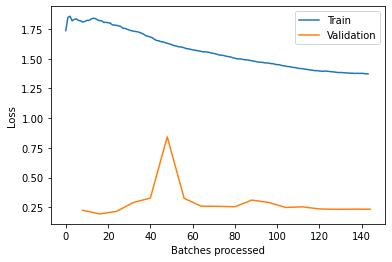

In [ ]:
learn.recorder.plot_losses()

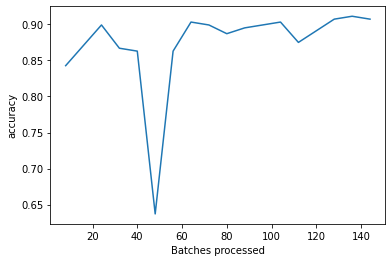

In [ ]:
learn.recorder.plot_metrics()

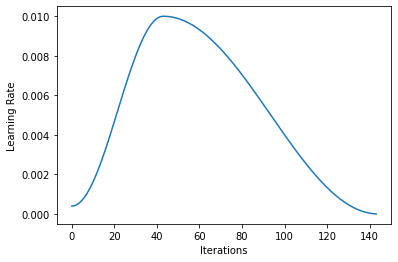

In [ ]:
learn.recorder.plot_lr()

Save model till now

In [ ]:
learn.save('/content/drive/My Drive/MIDAS Task 2/part1-299-s1')

- Unfreeze all the layers 
- Find optimal learning rate range to train further

In [ ]:
learn.load('/content/drive/My Drive/MIDAS Task 2/part1-299-s1');

In [ ]:
learn.unfreeze();
learn.clip_grad();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 7.59E-08


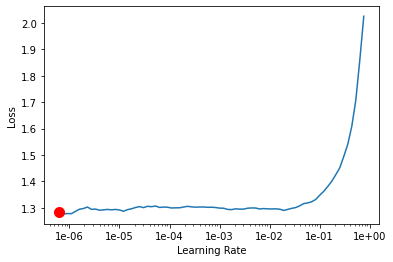

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

Train whole model for 10 more epochs with lr_range=(6e-5,
1e-4)

In [ ]:
learn.fit_one_cycle(18, slice(6e-7, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.262832,0.233448,0.911290,02:04
1,1.287657,0.231769,0.903226,01:59
2,1.295474,0.232993,0.903226,02:02
3,1.299372,0.234029,0.907258,02:01
4,1.315956,0.234268,0.895161,02:02
5,1.311629,0.233636,0.899194,02:03
6,1.300238,0.228348,0.911290,02:02


epoch,train_loss,valid_loss,accuracy,time
0,1.262832,0.233448,0.911290,02:04
1,1.287657,0.231769,0.903226,01:59
2,1.295474,0.232993,0.903226,02:02
3,1.299372,0.234029,0.907258,02:01
4,1.315956,0.234268,0.895161,02:02
5,1.311629,0.233636,0.899194,02:03
6,1.300238,0.228348,0.911290,02:02
7,1.293558,0.225219,0.899194,02:02
8,1.288861,0.223352,0.895161,02:03
9,1.294380,0.224992,0.895161,02:04


Plot losses and accuracies

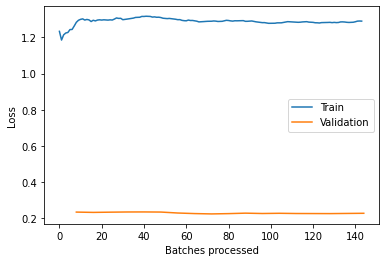

In [ ]:
learn.recorder.plot_losses()

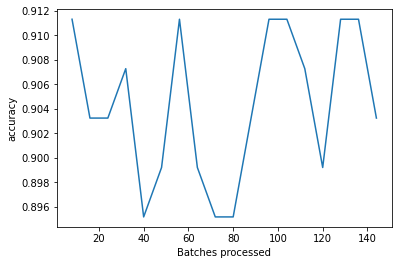

In [ ]:
learn.recorder.plot_metrics()

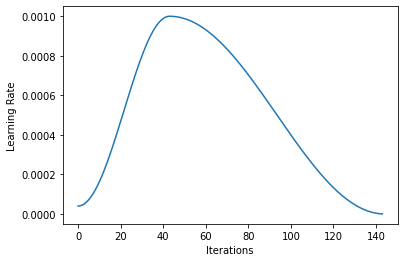

In [ ]:
learn.recorder.plot_lr()

Save model till now

In [ ]:
learn.save('/content/drive/My Drive/MIDAS Task 2/part1-299-s2')

## Image Size 512

In [ ]:
img_size = 512
batch_size = 80
data_512 = (ImageList.from_df(df, path='.')
        .split_by_idxs(train_idx, val_idx)
        .label_from_df(cols=['label']) 
        .transform(get_transforms(do_flip=False), size=img_size, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=batch_size).normalize()  
       )

Create learner with image size 512

In [ ]:
learn = cnn_learner(data_512, models.resnet18, pretrained=False, metrics=accuracy)

- Load model with image size 299
- Freeze all layers except last
- Clip gradient to 0.1
- Add mixup augmentation

In [ ]:
learn.load('/content/drive/My Drive/MIDAS Task 2/part1-299-s2');
learn.freeze();
learn.clip_grad();

In [ ]:
learn.mixup();

Find optimum lr to train further

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.10E-06
Min loss divided by 10: 4.79E-03


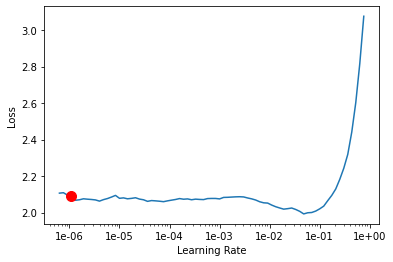

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

Fine tune just the head 

In [ ]:
learn.fit_one_cycle(12, 5e-3)

epoch,train_loss,valid_loss,accuracy,time
0,2.026365,1.427304,0.625000,02:11
1,1.919684,0.910046,0.754032,02:10
2,1.793300,1.220467,0.633065,02:10
3,1.743756,0.733718,0.794355,02:10
4,1.672433,0.467084,0.883065,02:09
5,1.608035,0.465402,0.879032,02:09
6,1.569100,0.351625,0.899194,02:10
7,1.526982,0.360596,0.907258,02:10
8,1.508860,0.323644,0.907258,02:11
9,1.490461,0.320427,0.923387,02:10


Plot losses, accuracies and lr

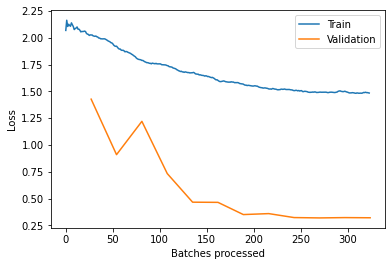

In [ ]:
learn.recorder.plot_losses()

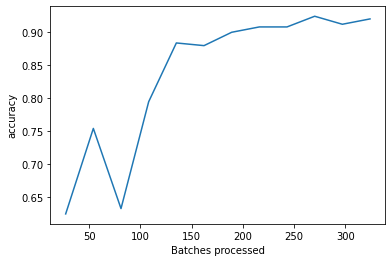

In [ ]:
learn.recorder.plot_metrics()

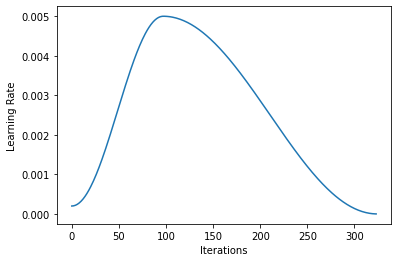

In [ ]:
learn.recorder.plot_lr()

Save model

In [ ]:
learn.save('/content/drive/My Drive/MIDAS Task 2/part1-512-s1')

- Unfreeze all layers
- Clip gradient to 0.1
- Use lr_finder to analyse learning rate vs losses

In [ ]:
learn.unfreeze();
learn.clip_grad();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.32E-06
Min loss divided by 10: 1.10E-05


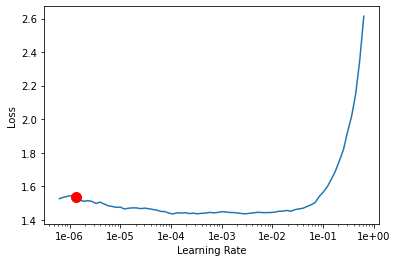

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
learn.fit_one_cycle(20, slice(1e-5, 1e-3))

epoch,train_loss,valid_loss,accuracy,time
0,1.443381,0.322037,0.915323,02:19
1,1.469703,0.322744,0.915323,02:18
2,1.458646,0.318159,0.915323,02:18
3,1.437752,0.320479,0.919355,02:17
4,1.442061,0.330985,0.903226,02:19
5,1.445410,0.303185,0.919355,02:19
6,1.430401,0.307454,0.911290,02:20
7,1.443011,0.344231,0.899194,02:19
8,1.455266,0.315694,0.919355,02:18
9,1.431384,0.318472,0.919355,02:21


Plot losses, accuracies and lr

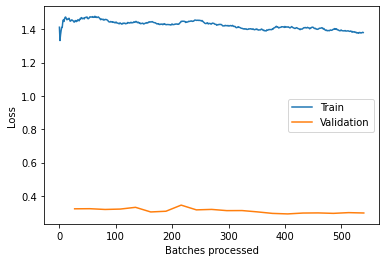

In [ ]:
learn.recorder.plot_losses()

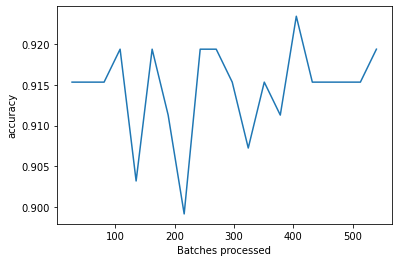

In [ ]:
learn.recorder.plot_metrics()

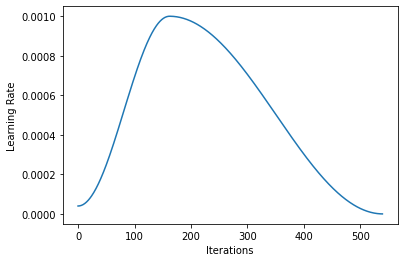

In [ ]:
learn.recorder.plot_lr()

Save model

In [ ]:
learn.save('/content/drive/My Drive/MIDAS Task 2/part1-512-s2')

## Image Size 600

In [6]:
img_size = 600
batch_size = 64
data_600 = (ImageList.from_df(df, path='.')
        .split_by_idxs(train_idx, val_idx)
        .label_from_df(cols=['label']) 
        .transform(get_transforms(do_flip=False), size=img_size, resize_method=ResizeMethod.SQUISH)
        .databunch(bs=batch_size).normalize()  
       )

- Create learner with size 600
- Freeze all layers except last
- Clip gradient to 0.1

In [7]:
learn = cnn_learner(data_600, models.resnet18, pretrained=False, metrics=accuracy)

In [14]:
learn.load('/content/drive/My Drive/MIDAS Task 2/part1-512-s2');
learn.freeze();
learn.clip_grad();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 2.29E-03


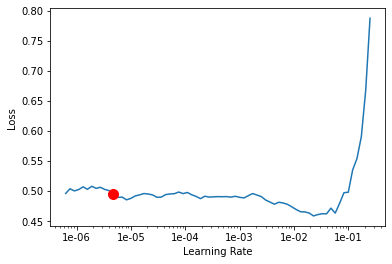

In [15]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

Fit the head

In [16]:
learn.fit_one_cycle(18, slice(2e-3))

epoch,train_loss,valid_loss,accuracy,time
0,0.477786,0.391649,0.907258,02:23
1,0.457514,0.355211,0.903226,02:21
2,0.422094,0.317764,0.903226,02:17
3,0.390545,0.268716,0.923387,02:19
4,0.359264,0.310378,0.883065,02:24
5,0.332504,0.258068,0.911290,02:20
6,0.310012,0.276874,0.903226,02:21
7,0.282542,0.250620,0.907258,02:22
8,0.272755,0.269429,0.907258,02:21
9,0.265987,0.246369,0.903226,02:23


Plot progress

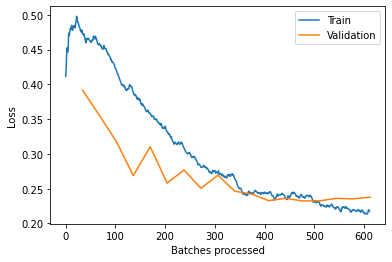

In [17]:
learn.recorder.plot_losses()

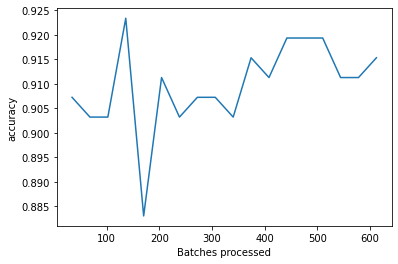

In [18]:
learn.recorder.plot_metrics()

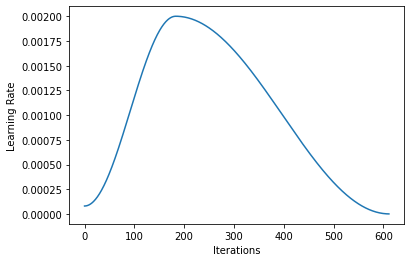

In [19]:
learn.recorder.plot_lr()

Save model

In [20]:
learn.save('/content/drive/My Drive/MIDAS Task 2/part1-600-s1')

- Unfreeze all layers
- Clip gradient
- Analyse learning rate vs loss to train further

In [8]:
learn.load('/content/drive/My Drive/MIDAS Task 2/part1-600-s1');
learn.unfreeze();
learn.clip_grad();

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.92E-04
Min loss divided by 10: 6.31E-08


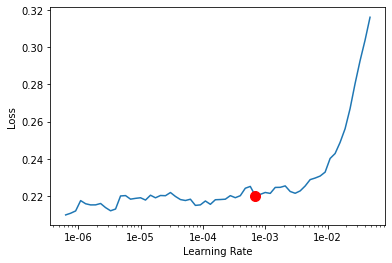

In [22]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [10]:
from fastai.callbacks import SaveModelCallback

In [11]:
lr = [1e-6, 1e-4, 7e-4]
learn.fit_one_cycle(24, lr, callbacks=[SaveModelCallback(learn, every='improvement', monitor='accuracy', name='best')])

epoch,train_loss,valid_loss,accuracy,time
0,0.224675,0.234526,0.911290,02:22
1,0.216878,0.230887,0.915323,02:20
2,0.216086,0.235872,0.923387,02:20
3,0.209904,0.231287,0.915323,02:21
4,0.212023,0.228803,0.923387,02:22
5,0.220130,0.229429,0.919355,02:22
6,0.218276,0.240880,0.919355,02:21
7,0.216024,0.217891,0.911290,02:21
8,0.210866,0.227569,0.915323,02:18
9,0.203026,0.221376,0.911290,02:21


Better model found at epoch 0 with accuracy value: 0.9112903475761414.
Better model found at epoch 1 with accuracy value: 0.9153226017951965.
Better model found at epoch 2 with accuracy value: 0.9233871102333069.
Better model found at epoch 13 with accuracy value: 0.9274193644523621.


Plot training progress

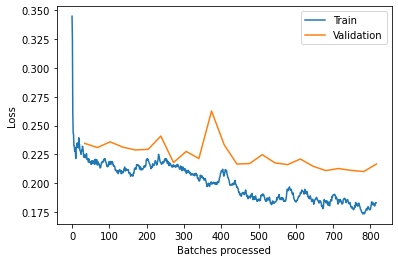

In [12]:
learn.recorder.plot_losses()

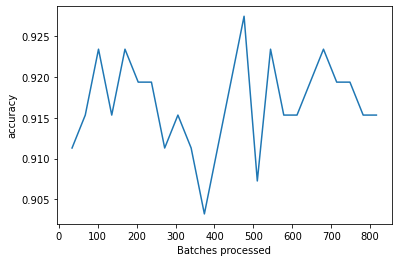

In [13]:
learn.recorder.plot_metrics()

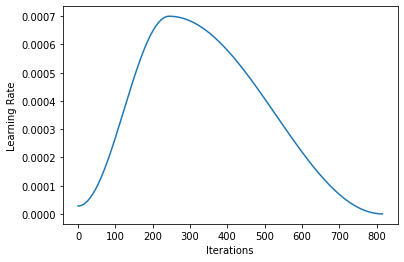

In [14]:
learn.recorder.plot_lr()

Save best model

In [18]:
learn.save('/content/drive/My Drive/MIDAS Task 2/part1-600-s2')

In [19]:
learn.load('/content/drive/My Drive/MIDAS Task 2/part1-600-s2');

Performance on training and validation set of the final model

In [21]:
learn.validate(dl=learn.data.train_dl)

[0.11939573, tensor(0.9554)]

In [24]:
learn.validate(dl=learn.data.valid_dl)

[0.21701972, tensor(0.9274)]

## Interpret performance  

In [22]:
interp = ClassificationInterpretation.from_learner(learn)

Plot top losses

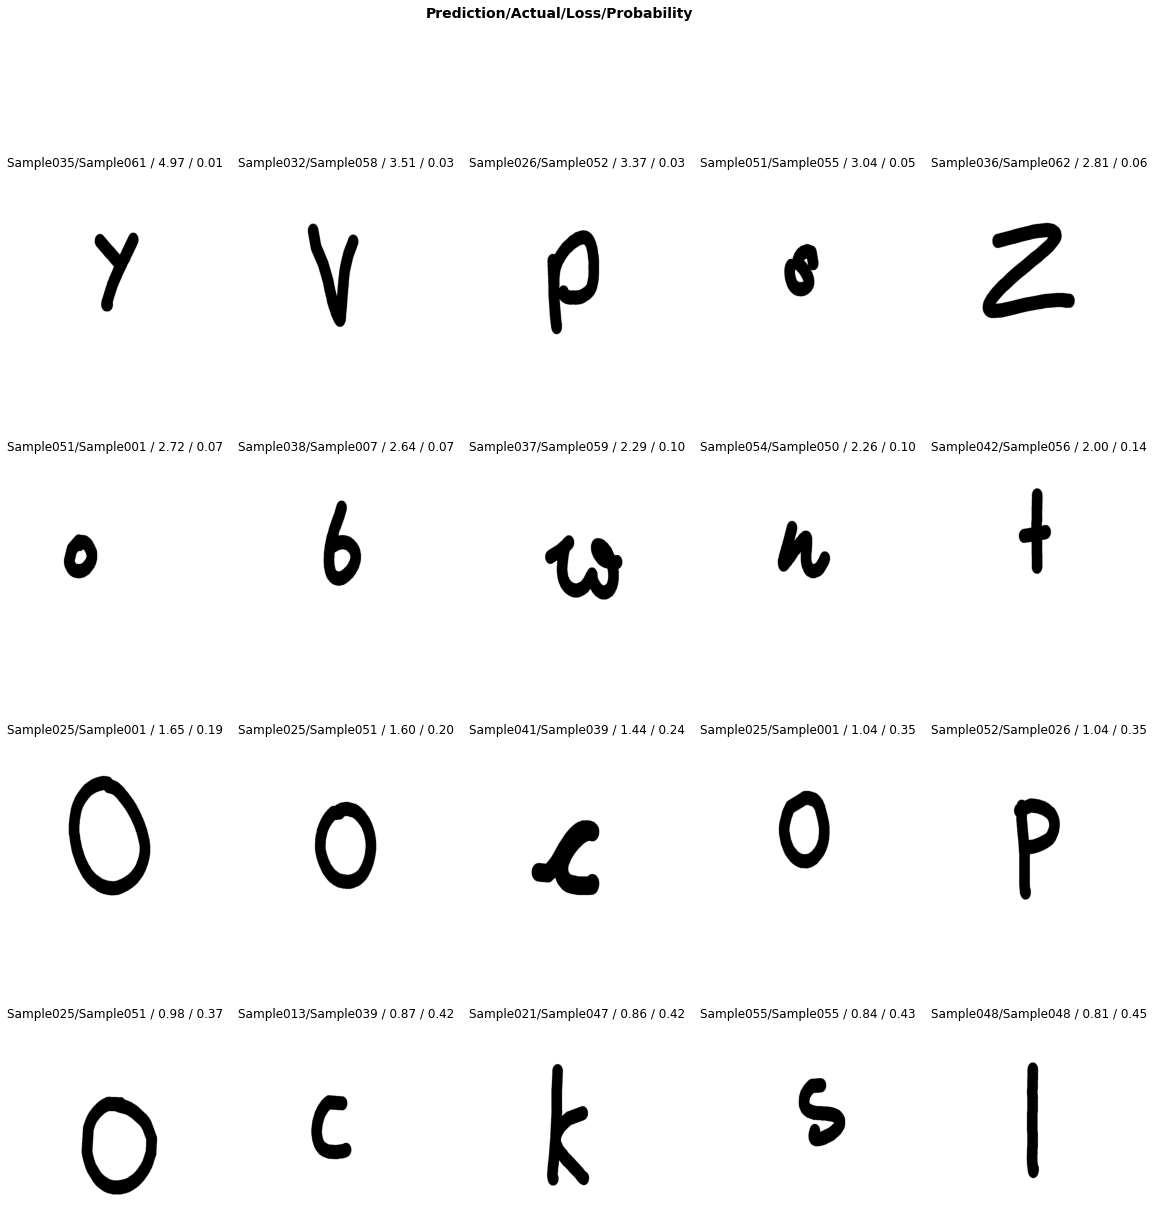

In [23]:
interp.plot_top_losses(20, figsize=(20, 20))

Plot Confusion Matrix

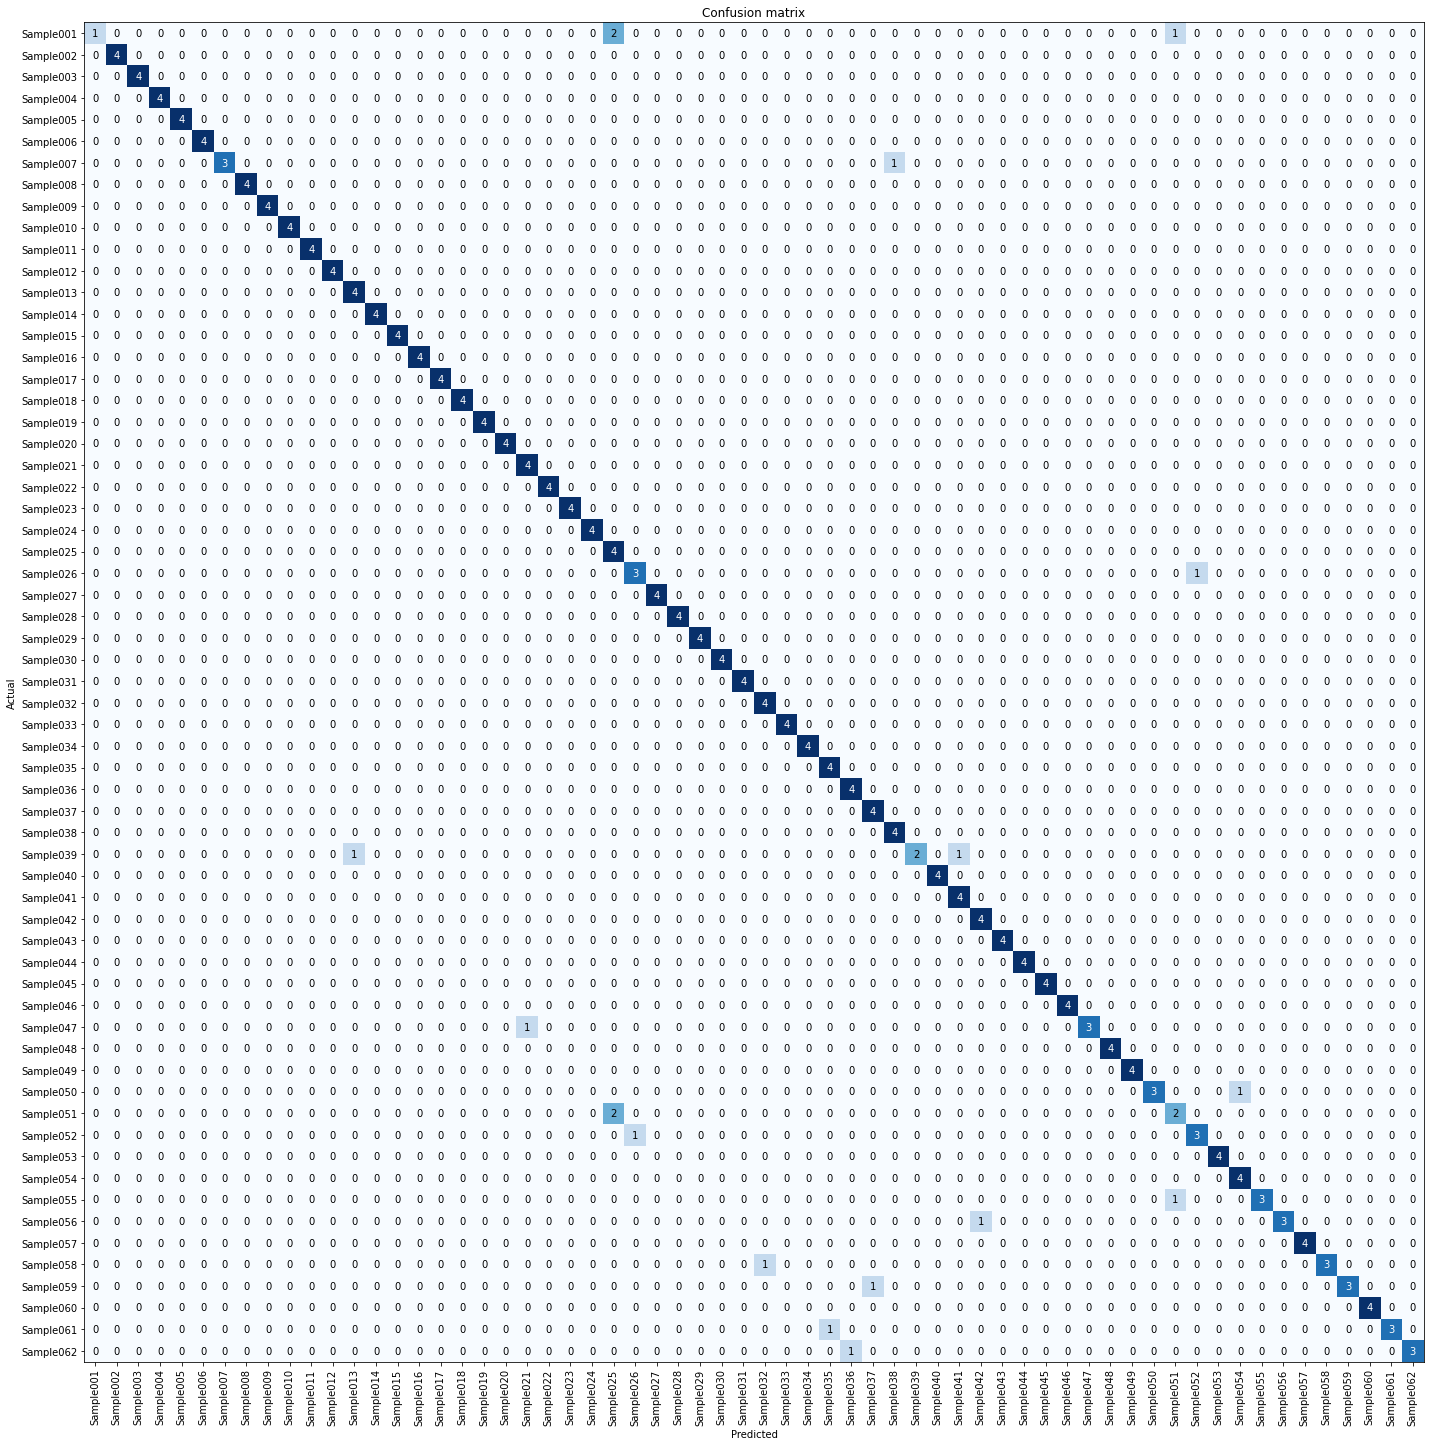

In [25]:
interp.plot_confusion_matrix(figsize=(20, 20))

Look at the most confused classes

In [26]:
interp.most_confused()

[('Sample001', 'Sample025', 2),
 ('Sample051', 'Sample025', 2),
 ('Sample001', 'Sample051', 1),
 ('Sample007', 'Sample038', 1),
 ('Sample026', 'Sample052', 1),
 ('Sample039', 'Sample013', 1),
 ('Sample039', 'Sample041', 1),
 ('Sample047', 'Sample021', 1),
 ('Sample050', 'Sample054', 1),
 ('Sample052', 'Sample026', 1),
 ('Sample055', 'Sample051', 1),
 ('Sample056', 'Sample042', 1),
 ('Sample058', 'Sample032', 1),
 ('Sample059', 'Sample037', 1),
 ('Sample061', 'Sample035', 1),
 ('Sample062', 'Sample036', 1)]